# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [10]:
import os

os.makedirs("module", exist_ok=True)

In [1]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary', lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler : Learning Rate Scheduler 객체. default : None. Epoch 단위로 LR을 변경
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ######### 1 epoch 학습 종료 -> LR을 변경 #########
        if lr_scheduler is not None :
            current_lr = lr_scheduler.get_last_lr()[0] # log 용
            lr_scheduler.step() # parameter update
            new_lr = lr_scheduler.get_last_lr()[0] # log 용
            if current_lr != new_lr : # lr이 변경되었으면
                print(f">>>>>>>>>>>>>>>Learning rate가 {current_lr}애서 {new_lr}으로 변경됨<<<<<<<<<<<<<<<<")

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [4]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


## utils.py


In [5]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Overwriting module/utils.py


In [2]:
import torch
import torch.nn as nn

from torchinfo import summary
from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_data_path = 'datasets'

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [4]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

len(train_loader)

235

In [5]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

# 모델의 크기 변경에 따른 성능변화


In [6]:
class SmallModel(nn.Module) :

    def __init__(self) :
        super().__init__()
        self.lr = nn.Linear(784, 10)

    def forward(self, X) :
        X = nn.Flatten()(X)
        output = self.lr(X)
        return output

In [7]:
small_model = SmallModel().to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)

In [9]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader,
    test_loader,
    small_model,
    loss_fn,
    optimizer,
    20,
    save_model_path='saved_models/small_model.pt',
    device=device,
    mode='multi',
    lr_scheduler=lr_scheduler
)

Epoch[1/20] - Train loss: 0.48459 Train Accucracy: 0.88260 || Validation Loss: 0.46153 Validation Accuracy: 0.89000
저장: 1 - 이전 : inf, 현재: 0.4615308802574873
Epoch[2/20] - Train loss: 0.37961 Train Accucracy: 0.90123 || Validation Loss: 0.36165 Validation Accuracy: 0.90570
저장: 2 - 이전 : 0.4615308802574873, 현재: 0.3616540845483541
Epoch[3/20] - Train loss: 0.33878 Train Accucracy: 0.90838 || Validation Loss: 0.32357 Validation Accuracy: 0.91180
저장: 3 - 이전 : 0.3616540845483541, 현재: 0.3235668696463108
Epoch[4/20] - Train loss: 0.31694 Train Accucracy: 0.91328 || Validation Loss: 0.30427 Validation Accuracy: 0.91440
저장: 4 - 이전 : 0.3235668696463108, 현재: 0.3042719602584839
>>>>>>>>>>>>>>>Learning rate가 0.001애서 0.0005으로 변경됨<<<<<<<<<<<<<<<<
Epoch[5/20] - Train loss: 0.30254 Train Accucracy: 0.91722 || Validation Loss: 0.29161 Validation Accuracy: 0.91870
저장: 5 - 이전 : 0.3042719602584839, 현재: 0.29160541696473957
Epoch[6/20] - Train loss: 0.29642 Train Accucracy: 0.91875 || Validation Loss: 0.28758 

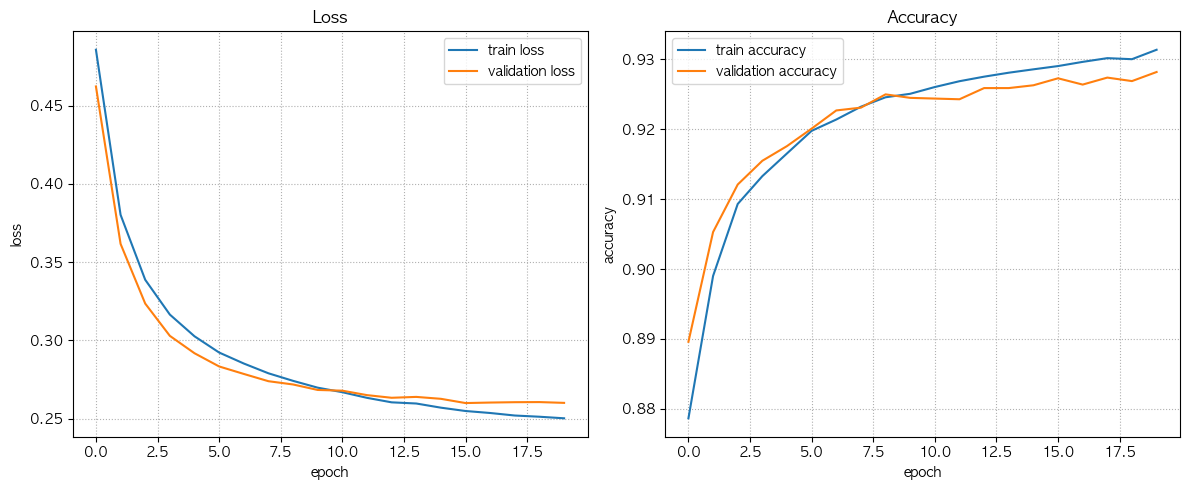

In [36]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [40]:
b = nn.Sequential(nn.Linear(1, 2), nn.ReLU())
b(torch.randn(10,1))

tensor([[0.4476, 3.1813],
        [0.1367, 1.2732],
        [0.0000, 0.2467],
        [0.0389, 0.6732],
        [0.0000, 0.2072],
        [0.0000, 0.0000],
        [0.1690, 1.4717],
        [0.0000, 0.2625],
        [0.0481, 0.7298],
        [0.1820, 1.5516]], grad_fn=<ReluBackward0>)

In [70]:
# 큰 모델

class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Linear() -> ReLU() : Sequential로 묶어서 정의
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [71]:
big_model = BigModel().to(device)
summary(big_model, (10, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [10, 10]                  --
├─Sequential: 1-1                        [10, 2048]                --
│    └─Linear: 2-1                       [10, 2048]                1,607,680
│    └─ReLU: 2-2                         [10, 2048]                --
├─Sequential: 1-2                        [10, 1024]                --
│    └─Linear: 2-3                       [10, 1024]                2,098,176
│    └─ReLU: 2-4                         [10, 1024]                --
├─Sequential: 1-3                        [10, 512]                 --
│    └─Linear: 2-5                       [10, 512]                 524,800
│    └─ReLU: 2-6                         [10, 512]                 --
├─Sequential: 1-4                        [10, 256]                 --
│    └─Linear: 2-7                       [10, 256]                 131,328
│    └─ReLU: 2-8                         [10, 256]           

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,
    big_model, loss_fn, optimizer,
    epochs,
    save_model_path = 'saved_models/big_model.pt',
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.15636 Train Accucracy: 0.95513 || Validation Loss: 0.17223 Validation Accuracy: 0.95010
저장: 1 - 이전 : inf, 현재: 0.17222780883312225
Epoch[2/100] - Train loss: 0.11355 Train Accucracy: 0.96738 || Validation Loss: 0.13602 Validation Accuracy: 0.96150
저장: 2 - 이전 : 0.17222780883312225, 현재: 0.13601575635839253
Epoch[3/100] - Train loss: 0.05700 Train Accucracy: 0.98332 || Validation Loss: 0.09254 Validation Accuracy: 0.97470
저장: 3 - 이전 : 0.13601575635839253, 현재: 0.09253590932057705
Epoch[4/100] - Train loss: 0.04422 Train Accucracy: 0.98743 || Validation Loss: 0.09178 Validation Accuracy: 0.97450
저장: 4 - 이전 : 0.09253590932057705, 현재: 0.0917789505678229
Epoch[5/100] - Train loss: 0.03856 Train Accucracy: 0.98910 || Validation Loss: 0.08770 Validation Accuracy: 0.97540
저장: 5 - 이전 : 0.0917789505678229, 현재: 0.08770379488996696
Epoch[6/100] - Train loss: 0.03893 Train Accucracy: 0.98857 || Validation Loss: 0.10338 Validation Accuracy: 0.97470
Epoch[7/100] - Train loss:

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [76]:
# 큰 모델

class DropoutModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear() -> ReLU() -> dropout() (앞의 Linear의 파라미터들을 drop out 한다): Sequential로 묶어서 정의
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [78]:
dout_model = DropoutModel().to(device)
summary(dout_model, (10, 1, 28, 28), device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader,
    dout_model, loss_fn, optimizer,
    epochs,
    save_model_path = 'saved_models/dout_model.pt',
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.74044 Train Accucracy: 0.64545 || Validation Loss: 0.74503 Validation Accuracy: 0.63860
저장: 1 - 이전 : inf, 현재: 0.7450281411409378
Epoch[2/100] - Train loss: 0.56784 Train Accucracy: 0.74908 || Validation Loss: 0.60884 Validation Accuracy: 0.74880
저장: 2 - 이전 : 0.7450281411409378, 현재: 0.6088389739394188
Epoch[3/100] - Train loss: 0.49489 Train Accucracy: 0.77077 || Validation Loss: 0.53906 Validation Accuracy: 0.76940
저장: 3 - 이전 : 0.6088389739394188, 현재: 0.5390598721802234
Epoch[4/100] - Train loss: 0.42391 Train Accucracy: 0.80187 || Validation Loss: 0.46731 Validation Accuracy: 0.80120
저장: 4 - 이전 : 0.5390598721802234, 현재: 0.4673089772462845
Epoch[5/100] - Train loss: 0.35923 Train Accucracy: 0.86477 || Validation Loss: 0.40258 Validation Accuracy: 0.85680
저장: 5 - 이전 : 0.4673089772462845, 현재: 0.402577244117856
Epoch[6/100] - Train loss: 0.31600 Train Accucracy: 0.90137 || Validation Loss: 0.37377 Validation Accuracy: 0.89670
저장: 6 - 이전 : 0.402577244117856, 현재

# Batch Normalization

-   Dense => BN => Activation


In [82]:
# 평균 : 0, 표준 편차 : 1 
class BatchNormModel(nn.Module):
    # Dense(WX+b) -> BatchNorm -> Activatation -> Dropout
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear() -> ReLU() -> dropout() (앞의 Linear의 파라미터들을 drop out 한다): Sequential로 묶어서 정의
        self.b1 = nn.Sequential(
            nn.Linear(784, 2048), # Fully connected layer (Dense Layer) -> parameter 이용해서 feature 추출
            nn.BatchNorm1d(2048), # 입력 1차원이기때문에 1d, 입력(출력) feature 갯수
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        output = self.out_block(X)
        return output

In [84]:
bn_model = BatchNormModel().to(device)
summary(bn_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormModel                           [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Linear: 2-1                       [100, 2048]               1,607,680
│    └─BatchNorm1d: 2-2                  [100, 2048]               4,096
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─BatchNorm1d: 2-6                  [100, 1024]               2,048
│    └─ReLU: 2-7                         [100, 1024]               --
│    └─Dropout: 2-8                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-9                       [100, 512]              

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [92]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)

info = optim.param_groups #optim의 attribute 묶어서 제공
info_dict = info[0]
print(info_dict.keys())

info_dict['lr'] #현재 lr

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])


0.001

In [104]:
# lr Scheduler (학습 도중 lr을 변경시키는 객체)에 의해 변화되는 lr을 시각화

import matplotlib.pyplot as plt

def plot_lr (title, lr_list) :
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0]
    plt.xticks(xticks)
    plt.xlabel('Epoch 수 or Step 수')
    plt.ylabel('학습률 - LR')
    plt.grid(True, linestyle=":")
    plt.show()

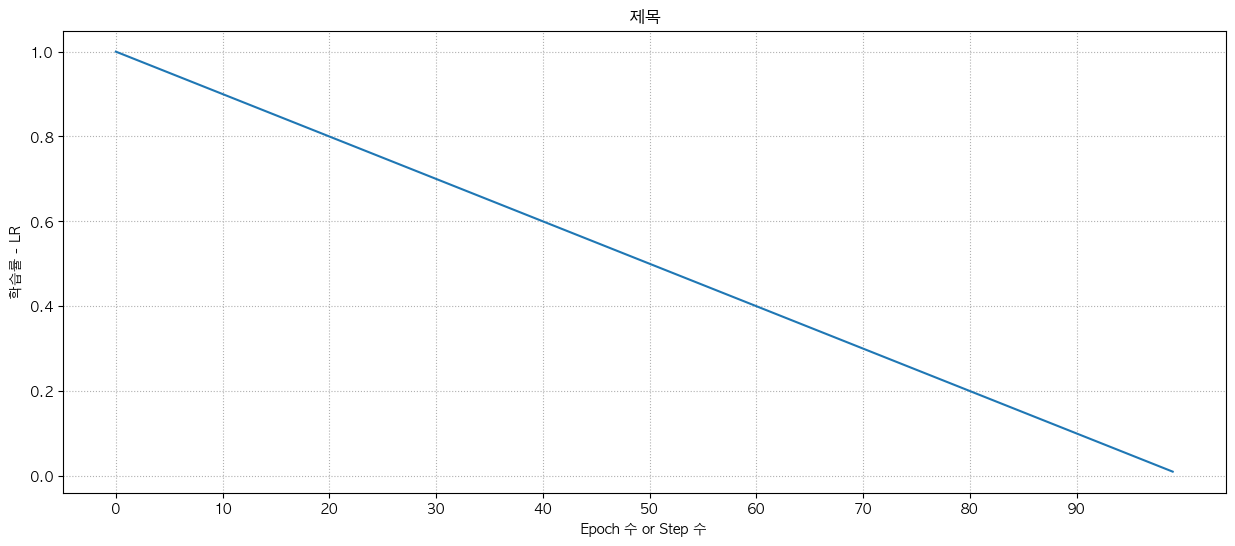

In [105]:
import numpy as np
plot_lr('제목', np.arange(1, 0.001, -0.01))

#### StepLR


In [109]:
#StepLR - 계단 형태로 lr을 변경, 특정 epoch마다 lr 특정 비율만큼 변경
# 학습 : 모델, loss 함수, optimizer (LR scheduler)
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)

#StepLR 생성
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optim, # 변경할 lr을 가지고있는 optimizer
    step_size=30, # 몇 번당 변경하는지 단위(epoch, step)를 지정 -> lr_sch.step() 몇 번 호출하면 변경할지
    gamma=0.5, # 변경 비율, 새 lr = 현재 lr * gamma    
)

# 현재 optimizer의 LR 조회
optim.param_groups[0]['lr'], step_lr_scheduler.get_last_lr()

(0.001, [0.001])

In [111]:
######### Train ###########
epochs = 300
step_size = 10 # 1 epoch당 step 수

lr_list = []

for epoch in range(epochs) :
    # step별 학습
    # 1. epoch 학습
    for _ in range(step_size) :
        # 1. step 학습 -> x,y device 이동 -> 모델 추론 -> loss 계산, grad 계산 ->  (데이터 없어서 걍 했다고 침)
        # weight parameter update -> 초기화

        # parameter update
        optim.step()
        #초기화
        optim.zero_grad()
    # lr 변경 요청 -> 1 epoch 끝나면 변경요청 -> 30 epoch 당 변경
    step_lr_scheduler.step()
    lr_list.append(step_lr_scheduler.get_last_lr()[0])
        

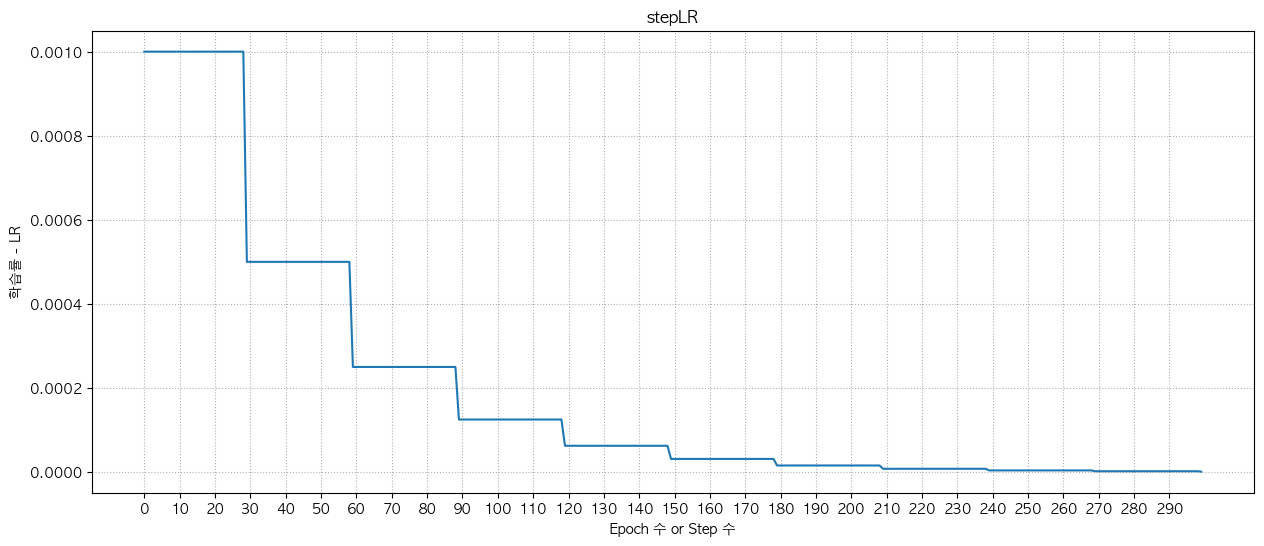

In [112]:
plot_lr('stepLR', lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [117]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, # lr 변경할 optimizer
    T_max = 10, # 변화주기 (T_max step/epoch 주기로 최대->최소 / 최소->최대)
    eta_min=1e-6  # lr 최소값, 최대값 : 초기 lr 값 (0.001) -> 0.000001  => 0.000001 ~ 0.001
)

In [118]:
lr_list2 = []
for epoch in range(epochs) :
    for _ in range(step_size) :
        # ... 학습
        optim.step()
        optim.zero_grad()
        
    ca_lr_scheduler.step() # lr update
    lr_list2.append(ca_lr_scheduler.get_last_lr()[0])

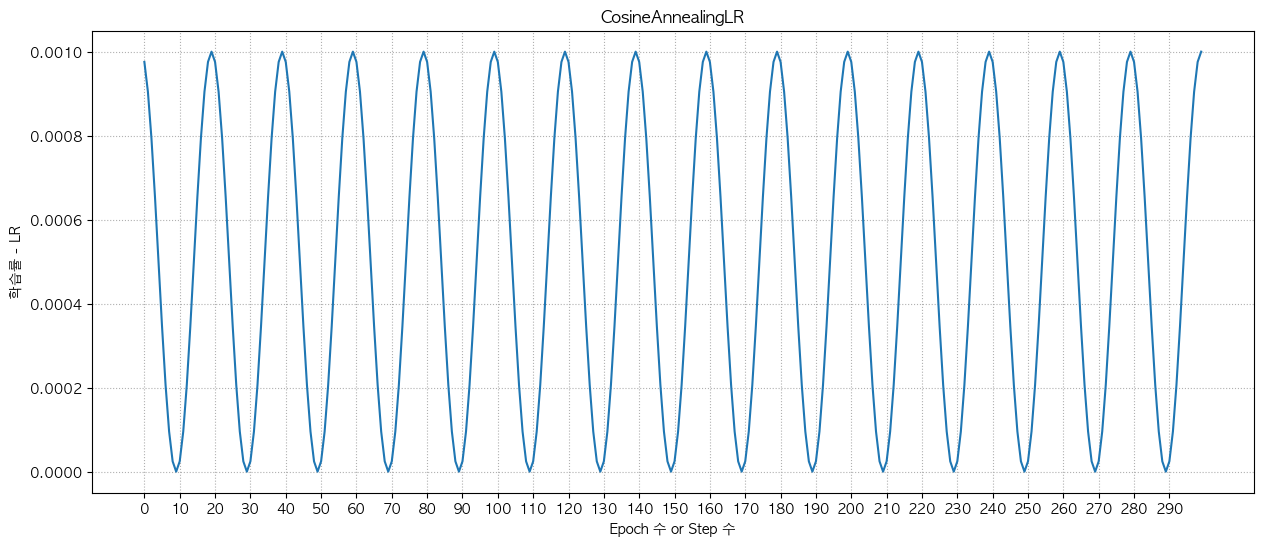

In [119]:
plot_lr('CosineAnnealingLR', lr_list2)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [121]:
optim = torch.optim.Adam(bn_model.parameters(), lr=0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=10, # 변화주기
    T_mult=2, # 새로운 T_0 생성, 현재 T_0 * T_mult (한 주기가 끝나면 새로운 주기) 10 -> 20 -> 40
    eta_min=1e-6 # 주기 최대 lr : 초기값 , 주기 최소 : eta_min
)

In [122]:
lr_list3 = []
for epoch in range(epochs) :
    for _ in range(step_size) :
        # 학습 ...
        optim.step()
        optim.zero_grad()
    cawr_lr_scheduler.step() # lr update
    lr_list3.append(cawr_lr_scheduler.get_last_lr())

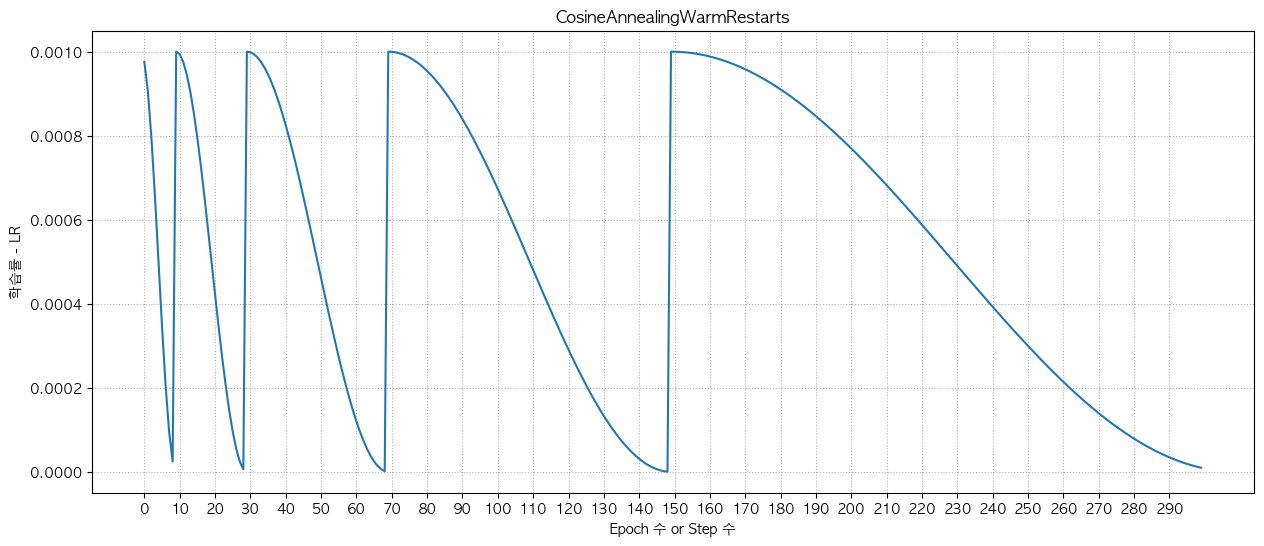

In [124]:
plot_lr('CosineAnnealingWarmRestarts', lr_list3)